# Cut-replace rate: how much is a sentence cut vs. replaced

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

/home/sl/Code/Research/interpretation-experiment/analysis/linguistics.py:141: UserWarning: 'unordered_content' distance is always normalized, so we're ignoring normalized=False
  warn("'unordered_content' distance is always normalized, so "

  warn("'unordered_content' distance is always normalized, so "



## 2 Cut-replace rate per tree

First build our data

In [5]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    order.append({'tree id': tree.id,
                  'root_content_words_count': len(root.content_words)})
    for sentence in tree.sentences.kept.all():
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': len(sentence.content_words),
                     'length / len(root)': len(sentence.content_words) / len(root.content_words),
                     'diff from root': \
                         root.unordered_content_distance(sentence)
                    })
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root_content_words_count', 'tree id'])

For each tree, plot the length of a sentence (number of content words relative to number content words of its tree root, so immune so minor changes) as a function of the difference from its tree root (difference taken as distance between bags of content words, so unordered).

On each plot there are 3 interesting spots:
* a sentence in the upper-left is very close to the root, both in length and content;
* a sentence in the upper-right is very different to the root, but about the same length; so it's different from its root, because many words are replaced;
* a sentence in the lower-right is very different to the root, and a lot shorter too; so it's different mainly because it's been croppped a lot.

So, the steeper the slope (downwards), the more a tree has its sentences cut, i.e. words removed. The flatter the slope, the more it has its sentences transformed, i.e. words replaced.

Plots are **ordered by number of content words in the root of the tree**, which correlates a lot to the slope.

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



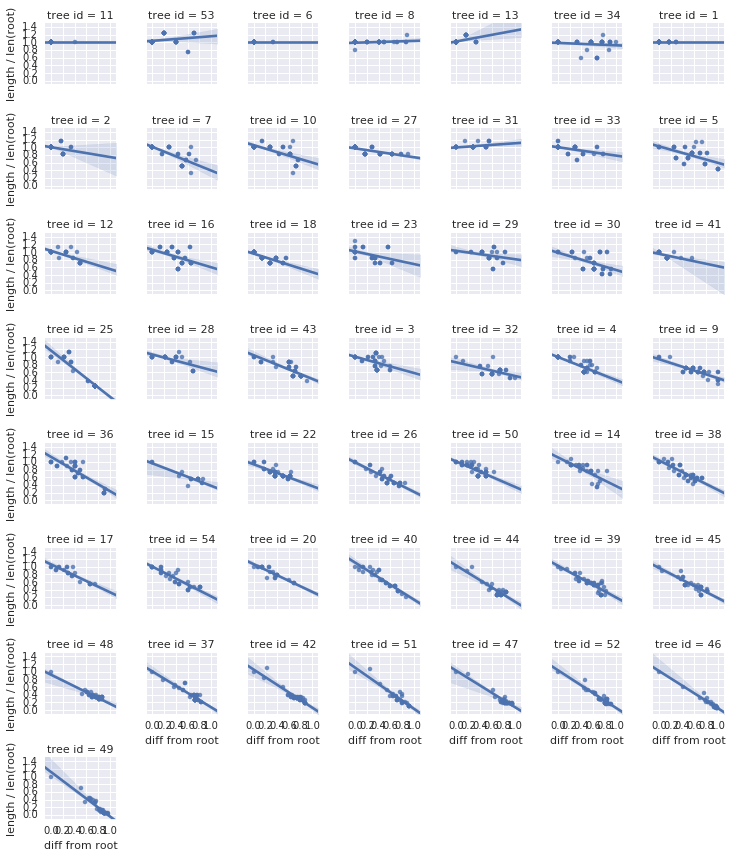

In [6]:
g = sb.lmplot(data=data,
              y='length / len(root)', x='diff from root',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.5))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/cut-replace_rate.png', dpi=300)

Most trees seem to give flat or negative slope (i.e. the shorter the sentence, the more different it is from its root).

Except #13.

## 3 Cut-replace rate ~ number of initial content words, which seem closely related

First build our data

In [7]:
slope_content = []
for tree in Tree.objects.experiment.all():
    tree_data = data[data['tree id'] == tree.id]
    slope, intercept, r_value, p_value, std_err = linregress(tree_data['diff from root'],
                                                             tree_data['length / len(root)'])
    slope_content.append({'tree id': tree.id,
                          'root content words count': len(tree.root.content_words),
                          'slope': slope})
slope_content = DataFrame(slope_content)

In the graph, we'll exclude trees with 15 or more initial content words:

In [8]:
threshold = 15
too_much_content = sorted([t.id for t in Tree.objects.experiment.all()
                           if len(t.root.content_words) >= threshold])
print('Trees with {} or more initial content words: {}'.format(threshold, too_much_content))

Trees with 15 or more initial content words: [37, 39, 42, 44, 45, 46, 47, 48, 49, 51, 52]


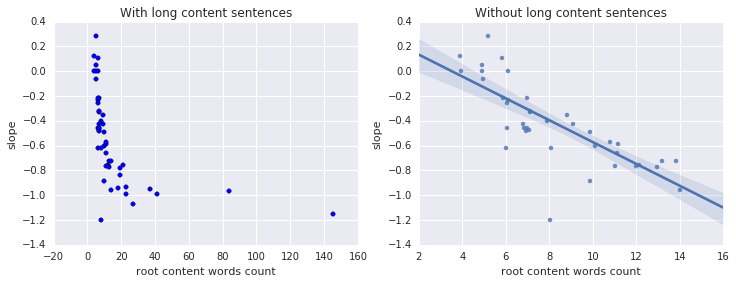

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(slope_content['root content words count'],
                slope_content['slope'])
axes[0].set_title('With long content sentences')
axes[0].set_xlabel('root content words count')
axes[0].set_ylabel('slope')
sb.regplot(ax=axes[1], data=slope_content[~slope_content['tree id'].isin(too_much_content)],
           x='root content words count', y='slope',
           x_jitter=.2, robust=True)
axes[1].set_title('Without long content sentences')
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/scatter_cut-replace_content.png', dpi=300)

In the graph above, a more negative 'slope' value means more shortening and less replacement (and vice-versa).

Remarks:
* With all the trees (left graph), it looks like $y = \frac{1-x}{x}$, or linear with segments.
* If we take out long content trees (right graph, so it's the left graph truncated at $x < 15$) it's pretty linear: more content words means linearly more cutting and less replacement when you transform. Less content words means you do more replacing. It makes sense: if a sentence is very long, you're likely to remember the beginning, or the end, and forget the rest. If a sentence is very short, you're likely to remember the gist and replace its words.

The outlier in the bottom left of the left graph (bottom middle in the right graph) is tree #25, which has a very catchy first part ("It's not just for work, it's not just for play"):

In [10]:
slope_content[slope_content['slope'] <= -1.18]

,root content words count,slope,tree id
21,8,-1.196291,25


The outlier in the top left of the right graph is tree #13, which is in fact *augmented* by subjects ("Dinosaurs and humans walked the earth at the same time"):

In [11]:
slope_content[slope_content['slope'] >= .2]

,root content words count,slope,tree id
12,5,0.283855,13


## 4 A few more details

Here are the root sentences for all trees, for a detailed look:

In [12]:
for tree in Tree.objects.experiment.all():
    print('Tree #{}'.format(tree.id))
    print('--------')
    print(tree.root.text)
    print()

Tree #1
--------
The young boy was suddenly hit by the little girl

Tree #2
--------
Don't forget to leave the door open when you leave the office

Tree #3
--------
Don't forget to leave the door open when you leave the office so that the cleaning person can come in

Tree #4
--------
Don't forget to leave the door open when you leave the office so that the people robbing us don't break the windows

Tree #5
--------
By the way, I can't come and fetch you, but it's only a dozen kilometers, you can hitch-hike down to the village

Tree #6
--------
Can you pay the rent a little earlier this month?

Tree #7
--------
They want to keep it all for themselves, and I don't blame them, but it ends up being a rich ghetto

Tree #8
--------
This crisis did not develop overnight and it will not be solved overnight

Tree #9
--------
Immediately after I become president I will confront this economic challenge head-on by taking all necessary steps

Tree #10
--------
We can't point the finger at any polit

Tree #13, which looks like an outlier in the cut-replace per tree graphs, has:

In [13]:
print("{} non-spam sentences".format(Tree.objects.get(id=13).sentences.kept.count()))

40 non-spam sentences


And here are their content words:

In [14]:
[s.content_words for s in Tree.objects.get(id=13).sentences.kept.all()]

[['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaura', 'human', 'walk', 'earth', 'time'],
 ['dinosor', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['din

The same for tree #25:

In [15]:
[s.content_words for s in Tree.objects.get(id=25).sentences.kept.all()]

[['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['ust', 'work', 'play', 'think', 'one', 'phone', 'use', 'whole', 'life'],
 ['ust', 'work', 'play', 'think', 'one', 'phone', 'use', 'whole', 'life'],
 ['work', 'play'],
 ['work', 'play'],
 ['ust', 'work', 'play', 'think', 'one', 'phone', 'use', 'whole', 'life'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play', 'think', 'one', 'phone', 'use', 'whole', 'life'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play', 'think', 'one', 'phone', 'use', 'whole', 'life'],
 ['work', 'play'],
 ['work', 'play', 'think'],
 ['work', 'play', 'think'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play'],
 ['work', 'play', 'think', 'one', 'phone', 'use', 'whole', 'life'],
 ['work', 'play', 'think', 'one', 'phone